# Quantum Self-Supervised Learning (qSSL) with MerLin

This approach is based on prior work by [Jaderberg et al.](https://github.com/bjader/QSSL).

This notebook demonstrates the quantum self-supervised learning framework comparing:
- **MerLin Quantum SSL**: Using photonic quantum circuits via Perceval
- **Classical SSL**: Using standard neural networks

on the first 2 classes of the CIFAR10 dataset. We encourage you to run the experiments with 5 classes as indicated in the [ReadMe](./README.md) to have a more complex tasks. For the purpose of this notebook, we run the self-supervised baseline for 2 epochs, and the linear probing for 10 epochs.

Both approaches will be trained for 2 epochs on SSL pre-training followed by 10 epochs of linear probing for evaluation.

## 1. Setup and Imports

In [15]:
import os
import json
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Import local modules
from data_utils import load_transformed_data, load_finetuning_data
from model import QSSL
from training_utils import train, linear_evaluation, save_results_to_json, get_results_dir
from linear_probing import FactorMultiplication

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Configuration and Data Loading

We first load the data for the self supervised training. In this dataset, each sample is made of 2 augmented views of the same image following a data augmentation strategy from [data_utils](./data_utils.py)

In [18]:
# Create a simple args object to mimic command line arguments from the scripts

class Args:
    def __init__(self):
        # Dataset configuration
        self.datadir = './data'
        self.classes = 2  # Using first 2 classes of CIFAR-10
        
        # Training configuration
        self.epochs = 2      # SSL pre-training epochs
        self.le_epochs = 10  # Linear evaluation epochs
        self.batch_size = 128
        self.ckpt_step = 1
        
        # Model configuration
        self.width = 8
        self.loss_dim = 128
        self.temperature = 0.07
        self.batch_norm = False

        # Classical Representation network
        self.layers = 2
        
        # MerLin quantum configuration
        self.modes = 10
        self.no_bunching = False
        
        # Backend flags
        self.merlin = False  # Will be set per experiment
        self.qiskit = False

# Create args object
args = Args()
print(f"Configuration: {args.classes} classes, {args.epochs} SSL epochs, {args.le_epochs} linear eval epochs")

Configuration: 2 classes, 2 SSL epochs, 10 linear eval epochs


In [9]:
# Load SSL training data (with augmentations)
print("Loading SSL training data...")
ssl_train_dataset = load_transformed_data(args)
print(f"SSL training batches: {len(ssl_train_dataset)}")
ssl_train_loader = torch.utils.data.DataLoader(
        ssl_train_dataset, batch_size=args.batch_size, shuffle=True
    )

# Load fine-tuning data (standard train/val split)
print("\nLoading fine-tuning data...")
ft_train_dataset, ft_val_dataset = load_finetuning_data(args)
print(f"Fine-tuning - Train batches: {len(ft_train_dataset)}, Val batches: {len(ft_val_dataset)}")
ft_train_loader = torch.utils.data.DataLoader(
        ft_train_dataset, batch_size=args.batch_size, shuffle=True
    )
ft_val_loader = torch.utils.data.DataLoader(
        ft_val_dataset, batch_size=args.batch_size, shuffle=True
    )
# Display sample data
sample_batch = next(iter(ssl_train_dataset))
print(f"\nSample SSL batch shape: {[x.shape for x in sample_batch[0]]} (two augmented views)")

ft_sample = next(iter(ft_train_dataset))
print(f"Sample fine-tuning batch: {ft_sample[0].shape} with labels {ft_sample[1]}")

Loading SSL training data...
SSL training dataset - Actual labels used: [0, 1]
SSL training batches: 10000

Loading fine-tuning data...
Fine-tuning training dataset - Actual labels used: [0, 1]
Fine-tuning validation dataset - Actual labels used: [0, 1]
Fine-tuning - Train batches: 10000, Val batches: 2000

Sample SSL batch shape: [torch.Size([3, 32, 32]), torch.Size([3, 32, 32])] (two augmented views)
Sample fine-tuning batch: torch.Size([3, 32, 32]) with labels 1



=== SSL Training Examples (Augmented Pairs) ===

=== Finetuning Training Examples ===


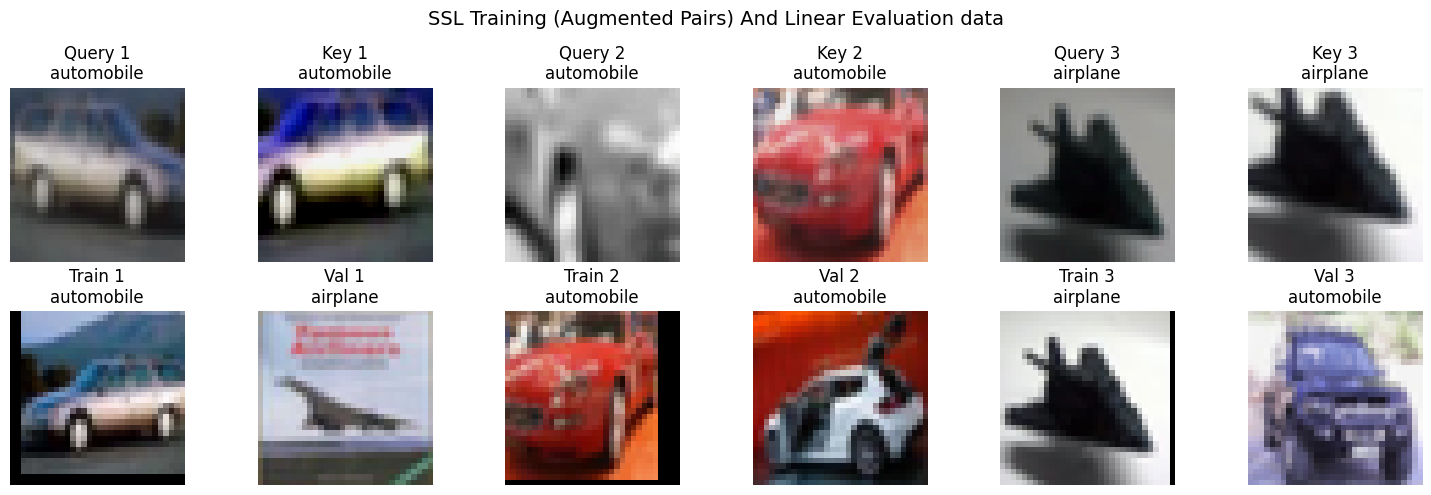

In [23]:
# We can visualize this dataset !
# Normalization values for denormalization
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
def denormalize_tensor(tensor, mean, std):
    """Denormalize a tensor for visualization"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
# CIFAR-10 class names
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
print("\n=== SSL Training Examples (Augmented Pairs) ===")
fig, axes = plt.subplots(2, 6, figsize=(15, 5))
fig.suptitle(
    "SSL Training (Augmented Pairs) And Linear Evaluation data", fontsize=14
)

for i in range(3):
    # Get an SSL sample (returns [query, key] pair and label)
    ssl_sample, label = ssl_train_dataset[i]

    # Display query image
    query_img = ssl_sample[0].clone()
    query_img = denormalize_tensor(query_img, mean, std)
    query_img = torch.clamp(query_img, 0, 1)
    axes[0, i * 2].imshow(query_img.permute(1, 2, 0))
    axes[0, i * 2].set_title(f"Query {i + 1}\n{class_names[label]}")
    axes[0, i * 2].axis("off")

    # Display key image (augmented version)
    key_img = ssl_sample[1].clone()
    key_img = denormalize_tensor(key_img, mean, std)
    key_img = torch.clamp(key_img, 0, 1)
    axes[0, i * 2 + 1].imshow(key_img.permute(1, 2, 0))
    axes[0, i * 2 + 1].set_title(f"Key {i + 1}\n{class_names[label]}")
    axes[0, i * 2 + 1].axis("off")
# Display finetuning training examples
print("\n=== Finetuning Training Examples ===")
for i in range(3):
    # Get a finetuning sample
    finetune_img, label = ft_train_dataset[i]

    # Display finetuning image
    ft_img = finetune_img.clone()
    ft_img = denormalize_tensor(ft_img, mean, std)
    ft_img = torch.clamp(ft_img, 0, 1)
    axes[1, i * 2].imshow(ft_img.permute(1, 2, 0))
    axes[1, i * 2].set_title(f"Train {i + 1}\n{class_names[label]}")
    axes[1, i * 2].axis("off")

    # Display validation image
    val_img, val_label = ft_val_dataset[i]
    val_img = val_img.clone()
    val_img = denormalize_tensor(val_img, mean, std)
    val_img = torch.clamp(val_img, 0, 1)
    axes[1, i * 2 + 1].imshow(val_img.permute(1, 2, 0))
    axes[1, i * 2 + 1].set_title(f"Val {i + 1}\n{class_names[val_label]}")
    axes[1, i * 2 + 1].axis("off")

plt.tight_layout()
plt.show()

## 3. Quantum SSL Training with MerLin

In [11]:
# Configure for quantum training
args.merlin = True
args.qiskit = False

print("=" * 60)
print("QUANTUM SSL TRAINING (MerLin Photonic)")
print("=" * 60)
print(f"Configuration: {args.modes} photonic modes, bunching={'enabled' if not args.no_bunching else 'disabled'}")

# Create quantum model
quantum_model = QSSL(args)
print(f"\nModel created with {sum(p.numel() for p in quantum_model.parameters() if p.requires_grad)} trainable parameters")

# Train quantum SSL model
print("\nStarting quantum SSL pre-training...")
start_time = time.time()

quantum_model, quantum_ssl_loss_history = train(
    model=quantum_model,
    train_loader=ssl_train_loader,
    args=args,
    results_dir = './results',
)

quantum_ssl_time = time.time() - start_time
print(f"Quantum SSL training completed in {quantum_ssl_time:.2f} seconds")
print(f"Final SSL loss: {quantum_ssl_loss_history[-1]:.4f}")

QUANTUM SSL TRAINING (MerLin Photonic)
Configuration: 10 photonic modes, bunching=enabled

 Defining the SSL model with 
 -Quantum (MerLin) 
 - 

 -> Building the quantum representation network with MerLin
Initial photon state: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0], no_bunching = False

Model created with 11198144 trainable parameters

Starting quantum SSL pre-training...
Saving training results to: ./results
 - Initial model saved - 


100%|██████████| 79/79 [01:53<00:00,  1.43s/it, Loss=2.5559]


epoch: 1/2, training loss: 4.998058291930187
 - Model saved at epoch 1/2 - 


100%|██████████| 79/79 [01:47<00:00,  1.36s/it, Loss=2.8296]

epoch: 2/2, training loss: 4.733158678948125
 - Model saved at epoch 2/2 - 
 - Final model saved to: ./results - 
Quantum SSL training completed in 220.77 seconds
Final SSL loss: 4.7332


## 4. Linear Probing for Quantum Model

In [16]:
print("\n" + "=" * 60)
print("QUANTUM MODEL - LINEAR EVALUATION")
print("=" * 60)

# Freezing the backbone
factor = 1/torch.pi
frozen_model = nn.Sequential(
            quantum_model.backbone,  # ResNet18 backbone (frozen)
            quantum_model.comp,  # Compression layer (frozen)
            nn.Sigmoid(),
            FactorMultiplication(factor),
            quantum_model.representation_network,  # Quantum/classical rep network (frozen)
            nn.Linear(quantum_model.rep_net_output_size, args.classes),  # Linear classifier (trainable)
        )
print(
    f"Trainable parameters in linear evaluation: {sum(p.numel() for p in frozen_model[2].parameters() if p.requires_grad) + sum(p.numel() for p in frozen_model[-1].parameters() if p.requires_grad)}"
)
# Freeze all layers except the final linear classifier
frozen_model.requires_grad_(False)
frozen_model[-1].requires_grad_(True)

# Perform linear evaluation
start_time = time.time()

trained_model, ft_train_losses, ft_val_losses, ft_train_accs, ft_val_accs = linear_evaluation(
    model=frozen_model,
    train_loader=ft_train_loader,
    val_loader=ft_val_loader,
    args=args,
    results_dir = './results',
)

quantum_eval_time = time.time() - start_time

print(f"\nQuantum linear evaluation completed in {quantum_eval_time:.2f} seconds")
print(f"Final validation accuracy: {ft_val_accs[-1]:.2f}%")
print(f"Best validation accuracy: {max(ft_val_accs):.2f}%")

# Store quantum results
quantum_total_time = quantum_ssl_time + quantum_eval_time
quantum_final_results = {
    'method': 'MerLin Quantum SSL',
    'ssl_epochs': args.epochs,
    'eval_epochs': args.le_epochs,
    'modes': args.modes,
    'bunching': not args.no_bunching,
    'ssl_loss_history': quantum_ssl_loss_history,
    'eval_loss_history': ft_val_losses,
    'eval_acc_history': ft_train_accs,
    'final_val_acc': ft_val_accs[-1],
    'best_val_acc': max(ft_val_accs),
    'total_training_time': quantum_total_time
}


QUANTUM MODEL - LINEAR EVALUATION
Trainable parameters in linear evaluation: 4006


100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Validation Loss=0.6823 - Validation Accuracy: 56.0000] 


Epoch 1/10: Train Acc = 0.6055, Val Acc = 0.7245


100%|██████████| 16/16 [00:08<00:00,  1.99it/s, Validation Loss=0.6662 - Validation Accuracy: 61.0000] 


Epoch 2/10: Train Acc = 0.7477, Val Acc = 0.7235


100%|██████████| 16/16 [00:06<00:00,  2.63it/s, Validation Loss=0.6642 - Validation Accuracy: 59.0000]


Epoch 3/10: Train Acc = 0.7517, Val Acc = 0.7055


100%|██████████| 16/16 [00:05<00:00,  2.67it/s, Validation Loss=0.6538 - Validation Accuracy: 52.0000]


Epoch 4/10: Train Acc = 0.7567, Val Acc = 0.6955


100%|██████████| 16/16 [00:06<00:00,  2.56it/s, Validation Loss=0.6483 - Validation Accuracy: 52.0000]


Epoch 5/10: Train Acc = 0.7567, Val Acc = 0.7160


100%|██████████| 16/16 [00:06<00:00,  2.64it/s, Validation Loss=0.6330 - Validation Accuracy: 56.0000]


Epoch 6/10: Train Acc = 0.7509, Val Acc = 0.7065


100%|██████████| 16/16 [00:06<00:00,  2.55it/s, Validation Loss=0.6158 - Validation Accuracy: 58.0000] 


Epoch 7/10: Train Acc = 0.7572, Val Acc = 0.7045


100%|██████████| 16/16 [00:06<00:00,  2.65it/s, Validation Loss=0.6159 - Validation Accuracy: 57.0000]


Epoch 8/10: Train Acc = 0.7595, Val Acc = 0.6885


100%|██████████| 16/16 [00:06<00:00,  2.31it/s, Validation Loss=0.6167 - Validation Accuracy: 52.0000]


Epoch 9/10: Train Acc = 0.7583, Val Acc = 0.7045


100%|██████████| 16/16 [00:06<00:00,  2.53it/s, Validation Loss=0.6465 - Validation Accuracy: 43.0000]

Epoch 10/10: Train Acc = 0.7586, Val Acc = 0.7030

Quantum linear evaluation completed in 391.53 seconds
Final validation accuracy: 0.70%
Best validation accuracy: 0.72%


## 5. Classical SSL Training for Comparison

In [20]:
# Configure for classical training
args.merlin = False
args.qiskit = False

print("\n" + "=" * 60)
print("CLASSICAL SSL TRAINING")
print("=" * 60)
print("Using standard MLP representation network")

# Create classical model
classical_model = QSSL(args)
print(f"\nModel created with {sum(p.numel() for p in classical_model.parameters() if p.requires_grad)} trainable parameters")

# Train classical SSL model
print("\nStarting classical SSL pre-training...")
start_time = time.time()

classical_model, classical_ssl_loss_history = train(
    model=classical_model,
    train_loader=ssl_train_loader,
    args=args,
    results_dir = './results',
)

classical_ssl_time = time.time() - start_time
print(f"Classical SSL training completed in {classical_ssl_time:.2f} seconds")
print(f"Final SSL loss: {classical_ssl_loss_history[-1]:.4f}")


CLASSICAL SSL TRAINING
Using standard MLP representation network

 Defining the SSL model with 
 -Classical ResNet18 
 - 

 -> Building the classical representation network 

Model created with 11182016 trainable parameters

Starting classical SSL pre-training...
Saving training results to: ./results
 - Initial model saved - 


100%|██████████| 79/79 [01:45<00:00,  1.34s/it, Loss=3.2389]


epoch: 1/2, training loss: 5.681952277316323
 - Model saved at epoch 1/2 - 


100%|██████████| 79/79 [01:45<00:00,  1.34s/it, Loss=2.9479]

epoch: 2/2, training loss: 5.054340748847285
 - Model saved at epoch 2/2 - 
 - Final model saved to: ./results - 
Classical SSL training completed in 211.52 seconds
Final SSL loss: 5.0543


## 6. Linear Probing for Classical Model

In [25]:
print("\n" + "=" * 60)
print("CLASSICAL MODEL - LINEAR EVALUATION")
print("=" * 60)

# Freezing the backbone
factor = torch.pi
frozen_model = nn.Sequential(
            classical_model.backbone,  # ResNet18 backbone (frozen)
            classical_model.comp,  # Compression layer (frozen)
            nn.Sigmoid(),
            FactorMultiplication(factor),
            classical_model.representation_network,  # Quantum/classical rep network (frozen)
            nn.Linear(classical_model.rep_net_output_size, args.classes),  # Linear classifier (trainable)
        )
print(
    f"Trainable parameters in linear evaluation: {sum(p.numel() for p in frozen_model[2].parameters() if p.requires_grad) + sum(p.numel() for p in frozen_model[-1].parameters() if p.requires_grad)}"
)
# Freeze all layers except the final linear classifier
frozen_model.requires_grad_(False)
frozen_model[-1].requires_grad_(True)

# Perform linear evaluation
start_time = time.time()

trained_classical_model, cl_train_losses, cl_val_losses, cl_train_accs, cl_val_accs = linear_evaluation(
    model=frozen_model,
    train_loader=ft_train_loader,
    val_loader=ft_val_loader,
    args=args,
    results_dir = './results')

classical_eval_time = time.time() - start_time

print(f"\nClassical linear evaluation completed in {classical_eval_time:.2f} seconds")
print(f"Final validation accuracy: {cl_val_accs[-1]:.2f}%")
print(f"Best validation accuracy: {max(cl_val_accs):.2f}%")

# Store classical results
classical_total_time = classical_ssl_time + classical_eval_time
classical_final_results = {
    'method': 'Classical SSL',
    'ssl_epochs': args.epochs,
    'eval_epochs': args.le_epochs,
    'ssl_loss_history': classical_ssl_loss_history,
    'eval_loss_history': cl_val_losses,
    'eval_acc_history': cl_train_accs,
    'final_val_acc': cl_val_accs[-1],
    'best_val_acc': max(cl_val_accs),
    'total_training_time': classical_total_time
}


CLASSICAL MODEL - LINEAR EVALUATION
Trainable parameters in linear evaluation: 18


100%|██████████| 16/16 [00:05<00:00,  2.68it/s, Validation Loss=0.6873 - Validation Accuracy: 43.0000]


Epoch 1/10: Train Acc = 0.5293, Val Acc = 0.4660


100%|██████████| 16/16 [00:05<00:00,  2.72it/s, Validation Loss=0.6885 - Validation Accuracy: 57.0000]


Epoch 2/10: Train Acc = 0.5980, Val Acc = 0.6395


100%|██████████| 16/16 [00:06<00:00,  2.44it/s, Validation Loss=0.6815 - Validation Accuracy: 60.0000]


Epoch 3/10: Train Acc = 0.5550, Val Acc = 0.7395


100%|██████████| 16/16 [00:06<00:00,  2.59it/s, Validation Loss=0.6747 - Validation Accuracy: 61.0000] 


Epoch 4/10: Train Acc = 0.6404, Val Acc = 0.7435


100%|██████████| 16/16 [00:05<00:00,  2.79it/s, Validation Loss=0.6690 - Validation Accuracy: 63.0000]


Epoch 5/10: Train Acc = 0.6601, Val Acc = 0.7175


100%|██████████| 16/16 [00:05<00:00,  2.74it/s, Validation Loss=0.6697 - Validation Accuracy: 63.0000]


Epoch 6/10: Train Acc = 0.6697, Val Acc = 0.7265


100%|██████████| 16/16 [00:05<00:00,  2.70it/s, Validation Loss=0.6707 - Validation Accuracy: 57.0000]


Epoch 7/10: Train Acc = 0.6751, Val Acc = 0.7090


100%|██████████| 16/16 [00:05<00:00,  2.71it/s, Validation Loss=0.6692 - Validation Accuracy: 53.0000]


Epoch 8/10: Train Acc = 0.6767, Val Acc = 0.7010


100%|██████████| 16/16 [00:05<00:00,  2.72it/s, Validation Loss=0.6532 - Validation Accuracy: 61.0000]


Epoch 9/10: Train Acc = 0.6810, Val Acc = 0.6950


100%|██████████| 16/16 [00:05<00:00,  2.76it/s, Validation Loss=0.6572 - Validation Accuracy: 59.0000]

Epoch 10/10: Train Acc = 0.6819, Val Acc = 0.6925

Classical linear evaluation completed in 374.25 seconds
Final validation accuracy: 0.69%
Best validation accuracy: 0.74%


## 7. Results Comparison and Visualization

In [26]:
print("\n" + "=" * 60)
print("RESULTS COMPARISON")
print("=" * 60)

# Print summary table
print(f"{'Method':<20} {'Final Acc (%)':<15} {'Best Acc (%)':<15} {'Time (s)':<12}")
print("-" * 65)
print(f"{'Quantum (MerLin)':<20} {quantum_final_results['final_val_acc']:<15.2f} {quantum_final_results['best_val_acc']:<15.2f} {quantum_final_results['total_training_time']:<12.1f}")
print(f"{'Classical':<20} {classical_final_results['final_val_acc']:<15.2f} {classical_final_results['best_val_acc']:<15.2f} {classical_final_results['total_training_time']:<12.1f}")

# Calculate improvement
accuracy_improvement = quantum_final_results['best_val_acc'] - classical_final_results['best_val_acc']
print(f"\nQuantum advantage: {accuracy_improvement:+.2f} percentage points")

if accuracy_improvement > 0:
    print("✓ Quantum SSL shows improvement over classical approach")
elif accuracy_improvement < -1:
    print("⚠ Classical SSL outperforms quantum approach")
else:
    print("≈ Both approaches show similar performance")


RESULTS COMPARISON
Method               Final Acc (%)   Best Acc (%)    Time (s)    
-----------------------------------------------------------------
Quantum (MerLin)     0.70            0.72            612.3       
Classical            0.69            0.74            585.8       

Quantum advantage: -0.02 percentage points
≈ Both approaches show similar performance


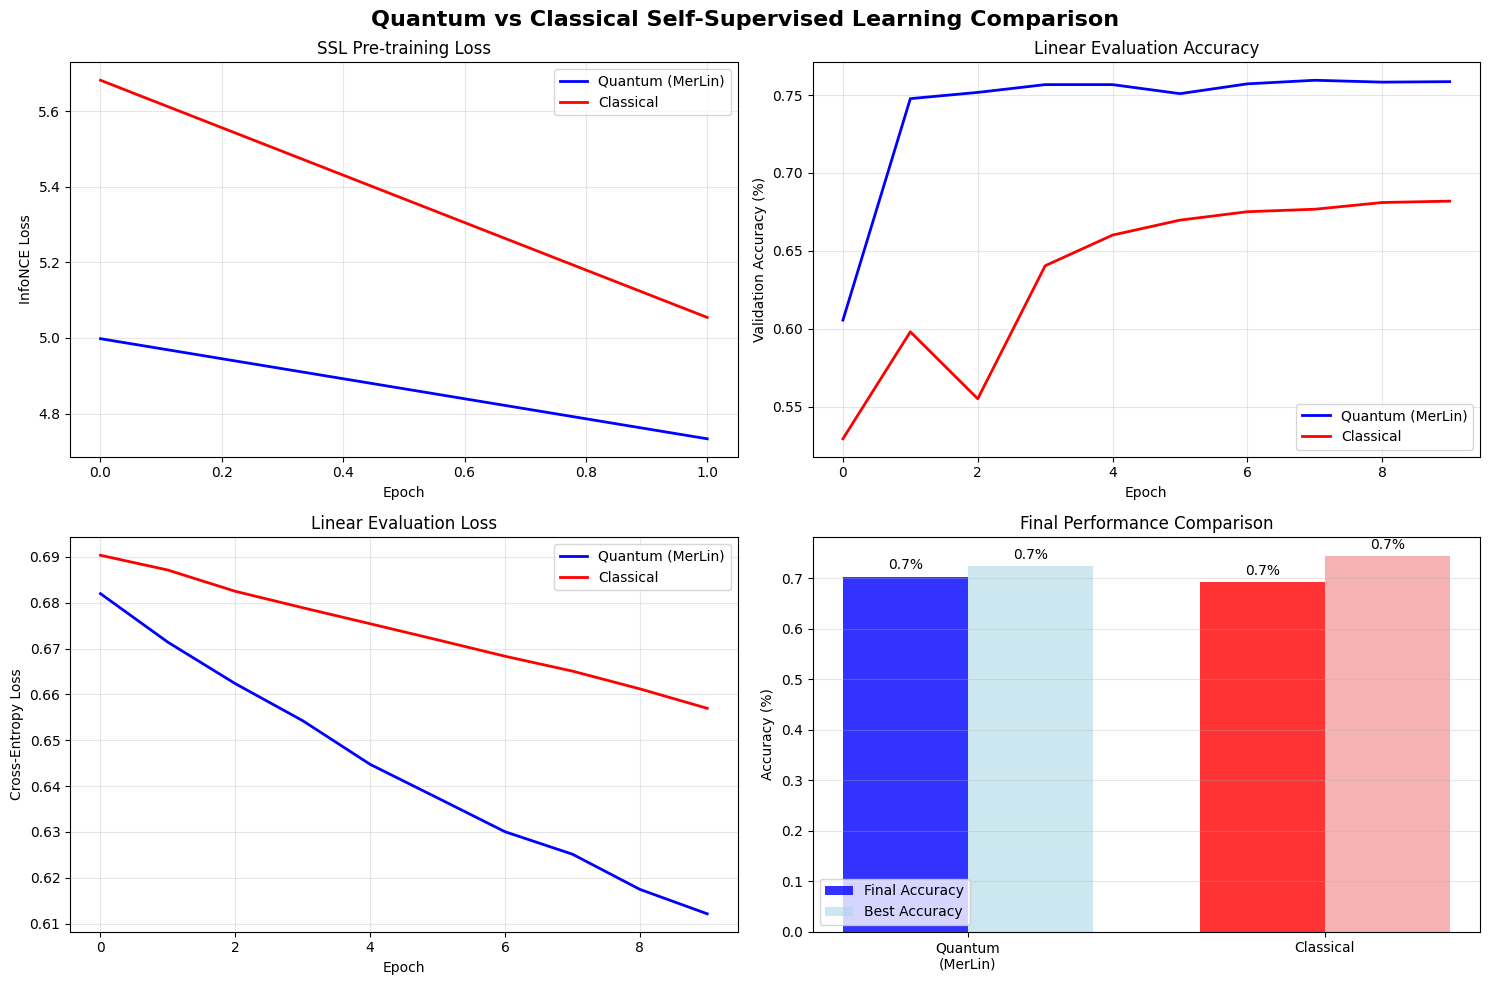

In [27]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Quantum vs Classical Self-Supervised Learning Comparison', fontsize=16, fontweight='bold')

# SSL Loss curves
axes[0, 0].plot(quantum_final_results['ssl_loss_history'], 'b-', label='Quantum (MerLin)', linewidth=2)
axes[0, 0].plot(classical_final_results['ssl_loss_history'], 'r-', label='Classical', linewidth=2)
axes[0, 0].set_title('SSL Pre-training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('InfoNCE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Linear evaluation accuracy
axes[0, 1].plot(quantum_final_results['eval_acc_history'], 'b-', label='Quantum (MerLin)', linewidth=2)
axes[0, 1].plot(classical_final_results['eval_acc_history'], 'r-', label='Classical', linewidth=2)
axes[0, 1].set_title('Linear Evaluation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Linear evaluation loss
axes[1, 0].plot(quantum_final_results['eval_loss_history'], 'b-', label='Quantum (MerLin)', linewidth=2)
axes[1, 0].plot(classical_final_results['eval_loss_history'], 'r-', label='Classical', linewidth=2)
axes[1, 0].set_title('Linear Evaluation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Cross-Entropy Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final performance comparison
methods = ['Quantum\n(MerLin)', 'Classical']
final_accs = [quantum_final_results['final_val_acc'], classical_final_results['final_val_acc']]
best_accs = [quantum_final_results['best_val_acc'], classical_final_results['best_val_acc']]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, final_accs, width, label='Final Accuracy', alpha=0.8, color=['blue', 'red'])
bars2 = axes[1, 1].bar(x + width/2, best_accs, width, label='Best Accuracy', alpha=0.6, color=['lightblue', 'lightcoral'])

axes[1, 1].set_title('Final Performance Comparison')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(methods)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[1, 1].annotate(f'{height:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    axes[1, 1].annotate(f'{height:.1f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Save Results to JSON

In [28]:
# Create comprehensive results dictionary
notebook_results = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'dataset': 'CIFAR-10',
        'classes': args.classes,
        'ssl_epochs': args.epochs,
        'linear_eval_epochs': args.le_epochs,
        'batch_size': args.batch_size,
    },
    'quantum_results': quantum_final_results,
    'classical_results': classical_final_results,
    'comparison': {
        'accuracy_improvement': accuracy_improvement,
        'quantum_advantage': accuracy_improvement > 0
    }
}

# Save results
results_filename = f'notebook_comparison_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(results_filename, 'w') as f:
    json.dump(notebook_results, f, indent=2)

print(f"\nResults saved to: {results_filename}")

# Display final summary
print("\n" + "=" * 80)
print("EXPERIMENT SUMMARY")
print("=" * 80)
print(f"Dataset: CIFAR-10 ({args.classes} classes)")
print(f"SSL Pre-training: {args.epochs} epochs")
print(f"Linear Evaluation: {args.le_epochs} epochs")
print(f"\nQuantum SSL (MerLin):")
print(f"  - Photonic modes: {quantum_final_results['modes']}")
print(f"  - Best accuracy: {quantum_final_results['best_val_acc']:.2f}%")
print(f"  - Training time: {quantum_final_results['total_training_time']:.1f}s")
print(f"\nClassical SSL:")
print(f"  - Best accuracy: {classical_final_results['best_val_acc']:.2f}%")
print(f"  - Training time: {classical_final_results['total_training_time']:.1f}s")
print(f"\nQuantum Advantage: {accuracy_improvement:+.2f} percentage points")
print("=" * 80)


Results saved to: notebook_comparison_results_20250829_171322.json

EXPERIMENT SUMMARY
Dataset: CIFAR-10 (2 classes)
SSL Pre-training: 2 epochs
Linear Evaluation: 10 epochs

Quantum SSL (MerLin):
  - Photonic modes: 10
  - Best accuracy: 0.72%
  - Training time: 612.3s

Classical SSL:
  - Best accuracy: 0.74%
  - Training time: 585.8s

Quantum Advantage: -0.02 percentage points


## Conclusion

Using these settings (2 epochs for self-supervised training and 10 for evaluation), there is no clear advantage of one algorithm over the other. We encourage to:
- Use more classes
- Use more modes for the MerLin settings
- Train for more epochs for the self-supervised training
- Evaluate for more epochs as well